In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
coursera_reviews = pd.read_csv('NLP Datasets/Coursera_reviews.csv.zip', compression = 'zip')
print(coursera_reviews.shape)
coursera_reviews.head()

(1454711, 5)


,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training


In [3]:
#lets see the duplicates
coursera_reviews[coursera_reviews[['reviews', 'reviewers', 'date_reviews', 'course_id']].duplicated()].sort_values('reviewers')

,reviews,reviewers,date_reviews,rating,course_id
818713,It was really great experience.,By \t M N H,"Sep 02, 2020",5,grammar-punctuation
818738,It was really great experience.,By \t M N H,"Sep 02, 2020",5,grammar-punctuation
301798,This course is amazing. Python is so easy lang...,By \t M R I,"Sep 15, 2020",5,python-data
301773,This course is amazing. Python is so easy lang...,By \t M R I,"Sep 15, 2020",5,python-data
1127812,"First of all, I am very happy to finish this c...",By \t M S R,"Jul 16, 2020",5,guitar
...,...,...,...,...,...
1104702,It was fun and useful\nTHANK YOU,By �� � � �,"Jun 17, 2020",5,how-things-work
1326649,I loved the way of learning and how this cours...,By ���� � �,"Jan 19, 2020",5,strategic-management
1326624,I loved the way of learning and how this cours...,By ���� � �,"Jan 19, 2020",5,strategic-management
264447,thanks providing this excellent course. these...,By 🐻 �,"Aug 22, 2020",5,learning-how-to-learn


In [4]:
#drop duplicates
coursera_reviews.drop_duplicates(subset = ['reviews', 'reviewers', 'date_reviews', 'course_id', 'rating'], inplace = True)
print(coursera_reviews.shape)

(519947, 5)


<Axes: ylabel='course_id'>

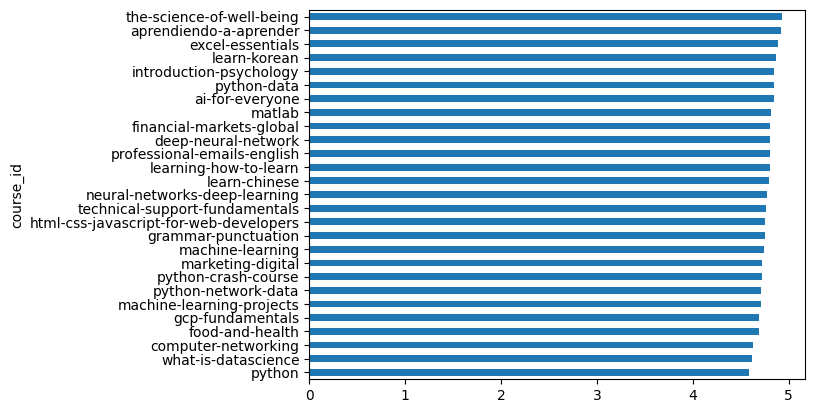

In [5]:
#add a review counts column so we know how many courses each user has reviewed
reviewer_counts = coursera_reviews['reviewers'].value_counts().to_dict()
coursera_reviews['reviewer_counts'] = coursera_reviews['reviewers'].apply(lambda x: reviewer_counts[x])

#add a course review column so we know how many reviews the course has
review_counts = coursera_reviews['course_id'].value_counts().to_dict()
coursera_reviews['course_reviews'] = coursera_reviews['course_id'].apply(lambda x: review_counts[x])

rank = coursera_reviews.groupby('course_id')[['course_reviews', 'rating']].mean().sort_values('course_reviews', ascending = False)
# the excellent courses are those with many reviews (say 3000) and high average rating 
best_courses = rank[(rank['course_reviews'] > 3000) & (rank['rating']>4.5)]
# to see the top 10 courses
best_courses['rating'].sort_values()[:10].plot(kind = 'barh')

In [6]:
#let's get more data to train the sentiment model on
reviews_data = pd.read_csv('NLP Datasets/reviews.csv.zip', compression = 'zip', index_col = 0)
print(reviews_data.head())

reviews_data2 = pd.read_csv('NLP Datasets/reviews_by_course.csv.zip', compression = 'zip', index_col = 0)
print(reviews_data2.head())

                                               Review  Label
Id                                                          
0                                good and interesting      5
1   This class is very helpful to me. Currently, I...      5
2   like!Prof and TAs are helpful and the discussi...      5
3   Easy to follow and includes a lot basic and im...      5
4   Really nice teacher!I could got the point eazl...      4
                                                       Review  Label
CourseId                                                            
2-speed-it                                             BOring      1
2-speed-it                                            Bravo !      5
2-speed-it                                           Very goo      5
2-speed-it  Great course - I recommend it for all, especia...      5
2-speed-it    One of the most useful course on IT Management!      5


In [7]:
#to merge the datasets together
coursera_reviews.rename({'reviews': 'Review', 'rating': 'Label'}, axis = 1, inplace= True)
df = pd.concat([reviews_data, reviews_data2, coursera_reviews[['Review', 'Label']]], ignore_index = True)
print(len(df) == (len(coursera_reviews) + len(reviews_data) + len(reviews_data2)))
df.sample(10)

True


,Review,Label
701350,Muy buenas lecciones,5
279326,Informative and Awesome,5
3623,Awesome course!,5
501862,would be better if there were more exercises.,4
269851,This course amazingly explains computer networ...,5
190465,"Very informative, interesting articles and gre...",4
93348,It gives you the basic idea of R coding. Swirl...,4
664117,"Overall,\nit's a great introduction to program...",5
6778,Very fast paced overview of the computer hardw...,5
447325,"It's very useful for my work and my family,I'm...",5


In [8]:
#first let us create a column to denote positively rated or not
df = df[df['Label'] != 3]
df['Positive'] = np.where(df['Label']> 3, 1, 0)
df.Positive.value_counts(normalize = True)

Positive
1    0.96908
0    0.03092
Name: proportion, dtype: float64

In [9]:
#since there is a lot of imbalance, lets add more negative reviews from another dataset
reviews_data3 = pd.read_csv('NLP Datasets/course_data_clean.csv', index_col = 0)
reviews_data3.rename({'reviews': 'Review', 'course_rating_int': 'Positive'}, axis = 1, inplace = True)
reviews_data3 = reviews_data3[reviews_data3['Positive']==0][['Review', 'Positive']]
df = pd.concat([df, reviews_data3], ignore_index = True)
df.tail(5)

,Review,Label,Positive
743383,The worst course I've ever taken. The professo...,NaN,0.0
743384,"I regret taking this course, I took it because...",NaN,0.0
743385,"Unfortunately, I found this course to be meh. ...",NaN,0.0
743386,This course is effectively entirely based off ...,NaN,0.0
743387,Personally did not find Computational Biomecha...,NaN,0.0


In [10]:
reviews_data4 = pd.read_csv('NLP Datasets/reviews2.csv')
reviews_data4 = reviews_data4[reviews_data4['label'] <= 3]
reviews_data4.rename({'review': 'Review', 'label': 'Label', 'label.1': 'Positive'}, axis = 1, inplace = True)
print(len(reviews_data4))
df = pd.concat([df, reviews_data4[['Review', 'Label', 'Positive']]], ignore_index = True)
df.tail(5)

9791


,Review,Label,Positive
753174,I want to give it 3 1/2 starts - sometimes the...,3.0,0.0
753175,I loved the non-UK / American basis for the wr...,3.0,0.0
753176,"It is perfect for beginners, but if youre an e...",3.0,0.0
753177,The course addresses quite precisely and pragm...,3.0,0.0
753178,"For those interested in taking exams, these qu...",2.0,0.0


In [11]:
df.dropna(subset = 'Review', inplace = True)

df.drop_duplicates(subset = 'Review', inplace = True)
df.Positive.value_counts(normalize = True)

Positive
1.0    0.94731
0.0    0.05269
Name: proportion, dtype: float64

The imbalance is seen to be very high as 95% of the data contains Positive reviews. This will be addressed.

In [12]:
dataset = df.copy() #to save the original highly imbalanced dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531942 entries, 0 to 753177
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Review    531942 non-null  object 
 1   Label     527192 non-null  float64
 2   Positive  531942 non-null  float64
dtypes: float64(2), object(1)
memory usage: 16.2+ MB


In [13]:
# in order to reduce the imbalance from 95/5 to 60/40
df_neg = df[df.Positive == 0]
df_pos = df[df.Positive == 1]
df_pos = df_pos.sample(int(1.5 * len(df_neg)), random_state = 24)
df = pd.concat([df_neg, df_pos], ignore_index = True)
df.Positive.value_counts(normalize = True)

Positive
1.0    0.6
0.0    0.4
Name: proportion, dtype: float64

## CREATING THE VECTORIZED DATASET


In [14]:
import re
import nltk
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

def text_preprocessing(data):
    '''Removes punctuation, digits and underscores from text. Returns the tokenized version in lowercase'''
    data = data.lower()
    data = re.sub(r'[_\',\.]+', ' ', data)
    data = re.sub(r'not\s*(?:\w+\s*)?bad', 'good', data)  
    data = re.sub('\d+', ' ', data)
    words = [word for word in nltk.word_tokenize(data)]
    data = ' '.join(words)
    return data

print(text_preprocessing("__ I am not '12 years' _ old. not so bad"))

i am not years old good


In [15]:
df['Review'] = df['Review'].apply(text_preprocessing)

df.Review

0        this course does not say anything about digiti...
1        this course doesn t contain any new informatio...
2        while there is some interesting content partic...
3        i do not find very interesting this course too...
4        a lot of speaking without any sense skip it at...
                               ...                        
70065    very interesting and well organized sometime i...
70066    muy buen curso si bien no soy de área financie...
70067    a real eye opener organized in a way that will...
70068    very useful course and bring insight on how to...
70069    very nice presentation of the tools plenty of ...
Name: Review, Length: 70070, dtype: object

### COUNT VECTORIZER IMPLEMENTATION (BOW)

In [16]:
#split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Positive'], test_size = 0.1, random_state = 42)

In [17]:
#Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df = 5, ngram_range = (1,3)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
len(vect.get_feature_names_out())

99001

In [18]:
np.array(vect.get_feature_names_out())[:50]

array(['aarabi', 'aarabi is', 'aarabi is an', 'aarabi is listed', 'ab',
       'abandon', 'abandoned', 'abandoned by', 'abandoned the',
       'abandoned the course', 'abandoned this', 'abandoned this course',
       'abandonment', 'abarca', 'abbreviations', 'abc', 'abierto',
       'abilities', 'abilities and', 'ability', 'ability and',
       'ability in', 'ability of', 'ability to', 'ability to convey',
       'ability to learn', 'ability to make', 'ability to teach', 'able',
       'able to', 'able to access', 'able to analyze', 'able to answer',
       'able to apply', 'able to be', 'able to build', 'able to code',
       'able to communicate', 'able to complete', 'able to connect',
       'able to develop', 'able to discuss', 'able to do',
       'able to download', 'able to explain', 'able to find',
       'able to finish', 'able to follow', 'able to get', 'able to give'],
      dtype=object)

## MODELLING

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
import xgboost as xgb
from sklearn.metrics import roc_auc_score, f1_score

In [20]:
# create a function we can use to train models for convenient manual hyperparameter tuning
def model_pred(model):
    ''' trains a model on the vectorized dataset and returns the model performance on train and test set'''
    metrics = {}
    model.fit(X_train_vectorized, y_train)
    pred = model.predict(X_test_vectorized)
    metrics['Train F1-score'] = f1_score(y_train, model.predict(X_train_vectorized))
    metrics['Test F1-score'] = f1_score(y_test, pred)
    metrics['Test ROC-AUC'] = roc_auc_score(y_test, pred)
    return metrics

In [21]:
lr_model = LogisticRegression(solver = 'saga', max_iter = 2000, C = 0.1)
model_pred(lr_model)

{'Train F1-score': 0.9571488403748495,
 'Test F1-score': 0.9316378908072795,
 'Test ROC-AUC': 0.9091482210763695}

In [22]:
xgb_model = xgb.XGBClassifier(n_estimators = 180, scale_pos_weight = 1.5, colsample_bytree = 0.7)
model_pred(xgb_model)

{'Train F1-score': 0.9331338211237779,
 'Test F1-score': 0.9107991849671723,
 'Test ROC-AUC': 0.8709226242922486}

In [23]:
nb_model = BernoulliNB(alpha = 1e-10, force_alpha = False)
model_pred(nb_model)

{'Train F1-score': 0.906123063035956,
 'Test F1-score': 0.8670664102274013,
 'Test ROC-AUC': 0.8130559109742217}

The Logistic Regression model performs slightly better than the XGBoost model. Also the logistic regression model can give a probabilistic output, so that is more suitable for this application.

In [24]:
# let's test the rating
user_input = input('Please enter your review for the course: ')
lr_model.predict_proba(vect.transform([text_preprocessing(user_input)]))[:, 1]

Please enter your review for the course: I did not really enjoy it


array([0.31438143])

### DOC2VEC IMPLEMENTATION (Paragraph Vector)

In [25]:
import gensim
from gensim.models import Doc2Vec
from tqdm import tqdm
from nltk import word_tokenize
from gensim.models.doc2vec import TaggedDocument

train, test = train_test_split(df[['Review', 'Positive']], test_size = 0.1, random_state = 42)
train_tagged = train.apply(lambda r: TaggedDocument(words = word_tokenize(r['Review']), tags = [r['Positive']]), axis = 1)
test_tagged = test.apply(lambda r: TaggedDocument(words = word_tokenize(r['Review']), tags = [r['Positive']]), axis = 1)


In [26]:
list(train_tagged[:1].values)

[TaggedDocument(words=['a', 'great', 'introductory', 'course', 'to', 'ai', 'that', 'resolves', 'preconceived', 'notions', 'of', 'killer', 'robots', 'and', 'dystopian', 'futures', 'the', 'course', 'provides', 'insights', 'into', 'what', 'ai', 'is', 'and', 'equips', 'one', 'with', 'a', 'solid', 'understanding', 'of', 'the', 'mentality', 'required', 'to', 'pursue', 'ai', 'ideas'], tags=[1.0])]

In [27]:
model_dbow = Doc2Vec(vector_size=20, negative=5, window = 2, min_count=5, workers = 4, epochs = 10)

# building and training the doc2vec model vocab on the train set
model_dbow.build_vocab(list(train_tagged.values))
model_dbow.train(train_tagged.values, total_examples = model_dbow.corpus_count, epochs = model_dbow.epochs)

In [28]:
# to create an array of paragraph vectored training and test examples
train_doc2vec = [model_dbow.infer_vector(x.words) for x in train_tagged.values]
test_doc2vec = [model_dbow.infer_vector(x.words) for x in test_tagged.values]
y_train_doc2vec = train['Positive']
y_test_doc2vec = test['Positive']

In [29]:
# a function for training of models for convenient hyperparam tuning
def model_pred_doc2vec(model):
    '''Trains a model on the doc2vec train data and returns the model performance on test and train'''
    metrics = {}
    model.fit(train_doc2vec, y_train_doc2vec)
    doc2vec_pred = model.predict(test_doc2vec)
    metrics['Train F1-score'] = f1_score(y_train_doc2vec, model.predict(train_doc2vec))
    metrics['Test F1-score'] = f1_score(y_test_doc2vec, doc2vec_pred)
    metrics['Test ROC-AUC score'] = roc_auc_score(y_test_doc2vec, doc2vec_pred)
    return metrics

In [30]:
# training a Logistic Regression model on the created set
lr_model2 = LogisticRegression(solver = 'liblinear')
model_pred_doc2vec(lr_model2)

{'Train F1-score': 0.8661870142263407,
 'Test F1-score': 0.8604807908335206,
 'Test ROC-AUC score': 0.8011162274372994}

In [38]:
xgb_model2 = xgb.XGBClassifier(n_estimators = 180, scale_pos_weight = 1.5, colsample_bytree = 0.7, max_depth = 4)
model_pred_doc2vec(xgb_model2)

{'Train F1-score': 0.8892053545998291,
 'Test F1-score': 0.8589487691284099,
 'Test ROC-AUC score': 0.7930552895236198}

In [32]:
from sklearn.naive_bayes import BernoulliNB
nb_model2 = BernoulliNB()
model_pred_doc2vec(nb_model2)

{'Train F1-score': 0.7552722939012384,
 'Test F1-score': 0.761430721148281,
 'Test ROC-AUC score': 0.6871142217693293}

Again, the logistic regression model performs slightly better than the xgboost on test set. However, the performance of these models on predicting the sentiment from text is not as good as the same models with the count vectorizer implementation.

Overall, the Count vectorizer implementation performs better than the Paragraph vector implementation, although the doc2vec can be improved by increasing the vector size (number of vectors required to represent  paragraph/document), but this is too computation heavy. Hence, I will be using the count vec logistic regression model for this application since it is low computation power and it works fine.

In [36]:
# to test the paragraph vector sentiment analysis model
test_string = input('Tell us how you feel about the course: ')
test_string_preprocessed = word_tokenize(text_preprocessing(test_string))
#print(test_string_preprocessed)
test_vector = model_dbow.infer_vector(test_string_preprocessed)
lr_model2.predict_proba([test_vector])[:,1]

Tell us how you feel about the course: great course


array([0.85126806])

## MODEL CALIBRATION
A model is said to be calibrated if for probabilistic output of r%, the event actually occurs r% of the time. In plain words, if the probability predicted is the ture probability of the event.

In [39]:
# to calibrate the CountVec log reg model 
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
calibrated_lr_model = CalibratedClassifierCV(estimator = lr_model, n_jobs = -1, cv = 3)
calibrated_lr_model.fit(X_test_vectorized, y_test)

CalibratedClassifierCV(cv=3,
                       estimator=LogisticRegression(C=0.1, max_iter=2000,
                                                    solver='saga'),
                       n_jobs=-1)

In [40]:
calib_pred = calibrated_lr_model.predict_proba(X_test_vectorized)[:,1]

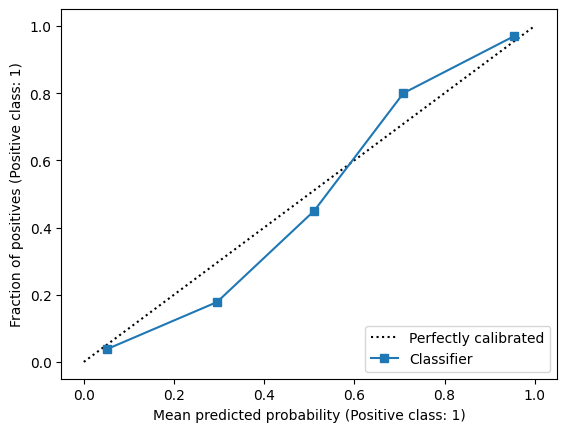

In [41]:
CalibrationDisplay.from_predictions(y_test, lr_model.predict_proba(X_test_vectorized)[:,1])
plt.show()

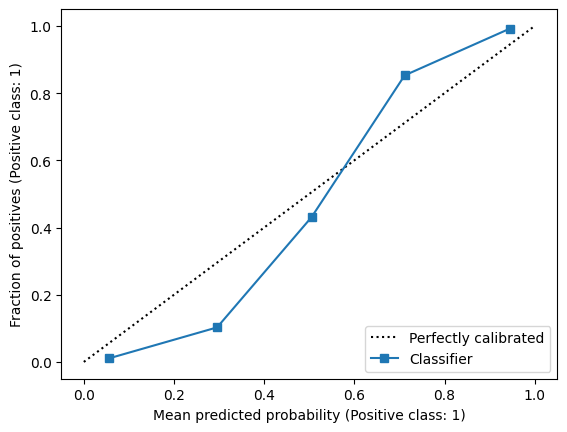

In [42]:
CalibrationDisplay.from_predictions(y_test, calib_pred)
plt.show()

The logistic regression model is alredy well calibrated as we see above and the sklearn calibratedcv is actually making it less calibrated, so we'll stick with the original log reg model.